In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import torch
torch.cuda.set_device(0)
import os
from pathlib import Path
import json
from fastai import *
from fastai.dataset import *
from fastai.conv_learner import *
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import patheffects

## Load Data

In [3]:
data_dir = Path('/mnt/data/extracts/pascal')
JPEGS = data_dir/'VOCdevkit/VOC2007/JPEGImages/'

In [4]:
train = json.load(open(data_dir/'pascal_train2007.json'))
val = json.load(open(data_dir/'pascal_val2007.json'))
test = json.load(open(data_dir/'pascal_test2007.json'))

### Create File Lookups

In [5]:
all_images = train['images'] + val['images'] + test['images']
fnid = {x['file_name']: x['id'] for x in all_images}

### Create DataFrames

In [6]:
def bb_np(bbox_hw):
    return [bbox_hw[1], bbox_hw[0], 
            bbox_hw[1] + bbox_hw[3], 
            bbox_hw[0] + bbox_hw[2]]

def bb_hw(bbox_np):
    return [bbox_np[1], bbox_np[0], 
            bbox_np[3] - bbox_np[1],
            bbox_np[2] - bbox_np[0]]

def create_df(d):
    anno = d['annotations']
    fnid = [{'file_name': x['file_name'], 'image_id': x['id']} for x in d['images']]
    cats = [{'category_id': x['id'], 'category_name': x['name']} for x in d['categories']]
    anno_df = pd.DataFrame.from_dict(anno)
    fname_df = pd.DataFrame.from_dict(fnid)
    cat_df = pd.DataFrame(cats)
    df = pd.merge(anno_df, cat_df, how='inner', on='category_id')
    df = pd.merge(df, fname_df, how='inner', on='image_id')
    df['bbox_np'] = df['bbox'].apply(lambda x: bb_np(x))
    df = df.loc[df.ignore != 1]
    return df

def get_largest(df):
    return df.sort_values('area', ascending=False).groupby(['image_id']).first().reset_index()

In [7]:
train_df = create_df(train)
val_df = create_df(val)
test_df = create_df(test)
comb_df = pd.concat([train_df, val_df], axis=0)

In [8]:
trn_lrg_df = get_largest(train_df)
val_lrg_df = get_largest(val_df)
comb_lrg_df = get_largest(comb_df)

### Setup Plotting Functions

In [9]:
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])
    
def draw_anno(ax, x, y, anno):
    text = ax.text(x, y, anno, fontsize=14, color='white', weight='bold', 
                   verticalalignment='top')
    draw_outline(text, 1)
    
def draw_rect(ax, bbox, edgecolor='white'):
    x = bbox[0]
    y = bbox[1]
    h = bbox[2]
    w = bbox[3]
    ax.add_patch(patches.Rectangle((x, y), h, w, fill=False, edgecolor=edgecolor, lw=2))
    
def show_img(img, ax=None, figsize=(16, 8)):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(img)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    return ax
    
def plot_idx(image_id, figsize=(16, 8)):
    rel = comb_lrg_df.loc[comb_lrg_df.image_id == image_id].iloc[0]
    fname = rel.file_name
    cat = rel.category_name
    bbox = rel.bbox
    f_path = JPEGS/fname
    img = open_image(f_path)
    ax = show_img(img, figsize=figsize)
    draw_rect(ax, bbox)
    draw_anno(ax, bbox[0], bbox[1], cat)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

## Multilabel Classification

In [10]:
TMP = data_dir/'tmp'
TMP.mkdir(exist_ok=True)
MC_CSV = TMP/'MC.CSV'
MODEL = Path('/mnt/models/pascal')
f_model = resnet34
sz = 224

In [11]:
def create_mc_df(df, unique=True):
    df1 = df.copy()
    df1 = df1[['file_name', 'image_id', 'category_name']]
    if unique:
        df2 = (df1.groupby(['file_name', 'image_id'])
               .apply(lambda x: pd.Series({'m_cat': ' '.join(set(x.category_name))}))
               .reset_index())
    else:
        df2 = (df1.groupby(['file_name', 'image_id'])
               .apply(lambda x: pd.Series({'m_cat': ' '.join(x.category_name)}))
               .reset_index())
    df2 = (df2[['file_name', 'm_cat']]
           .rename(columns={'file_name': 'fname'}))
    return df2

In [12]:
def matching_cl(onehot_y, md, thresh=0):
    return list(np.array(md.classes)[np.where(onehot_y > thresh)])

In [13]:
def plot_mc(x, y, thresh=0):
    fig, axes = plt.subplots(3, 4, figsize=(12, 8))
    for i, ax in enumerate(axes.flat):
        show_img(np.squeeze(md.trn_ds.denorm(x[i])), ax=ax, figsize=(12, 8))
        txt_x = 0
        txt_y = 0
        for cl in matching_cl(y[i], md, thresh):
            draw_anno(ax, txt_x, txt_y, cl)
            txt_y += 20
    plt.tight_layout()

In [14]:
mc_df = create_mc_df(train_df)
mc_df.to_csv(MC_CSV, index=False)

In [15]:
tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_side_on, 
                       max_zoom=1.1, crop_type=CropType.NO)
md = ImageClassifierData.from_csv(MODEL, JPEGS, MC_CSV, tfms=tfms, skip_header=True)

In [16]:
x, y = list(next(iter(md.trn_dl)))
x, y = to_np(x), to_np(y)

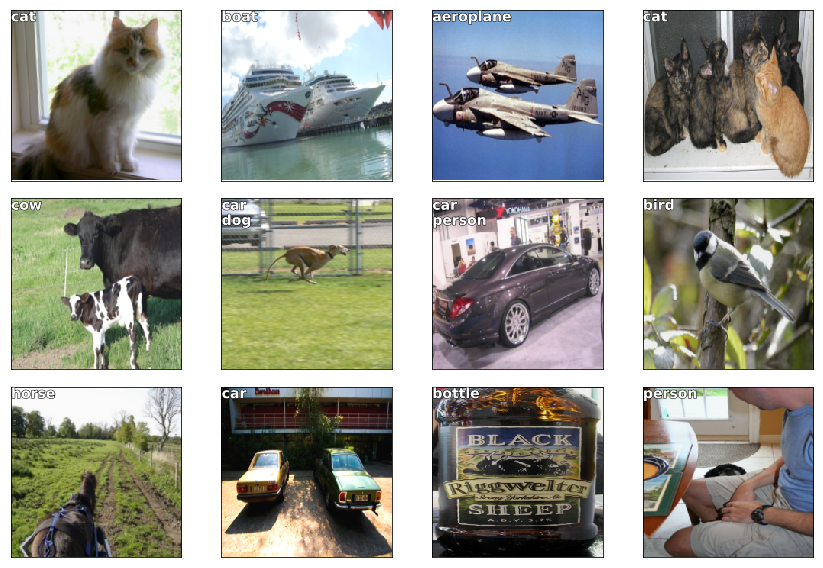

In [156]:
plot_mc(x, y)

In [17]:
learn = ConvLearner.pretrained(f_model, md)
learn.opt_fn = optim.Adam

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/ubuntu/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:03<00:00, 26046634.96it/s]


HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   <lambda>                  
    0      1.068195   5.01955    0.818134  



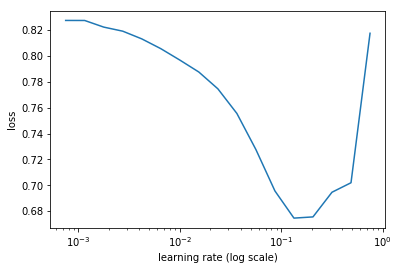

In [18]:
learn.lr_find()
learn.sched.plot()
lr = 2e-2

In [19]:
learn.fit(lr, n_cycle=1, cycle_len=3)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   <lambda>                  
    0      0.303233   0.122145   0.959848  
    1      0.168022   0.081985   0.973603                  
    2      0.120836   0.078955   0.973896                  



[0.07895541, 0.9738957285881042]

In [20]:
learn.fit(lr, n_cycle=1, cycle_len=2, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   <lambda>                   
    0      0.106918   0.081339   0.97355   
    1      0.086961   0.075432   0.974872                   



[0.07543205, 0.9748722985386848]

In [21]:
lrs = np.array([lr/100, lr/10, lr])
learn.freeze_to(-2)
learn.lr_find(lrs/1000)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 84%|████████▍ | 27/32 [00:20<00:03,  1.30it/s, loss=0.347] 

In [22]:
preds = to_np(predict_batch(learn.model, x))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


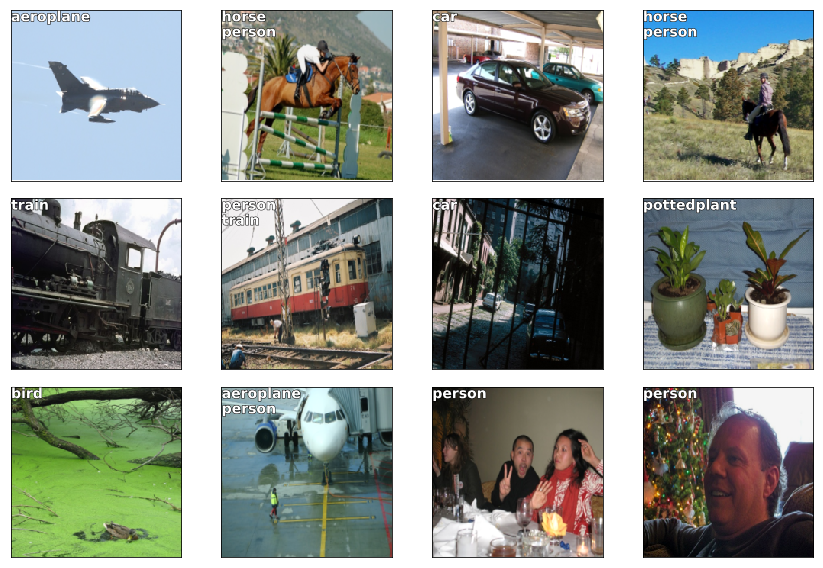

In [24]:
plot_mc(x, y)

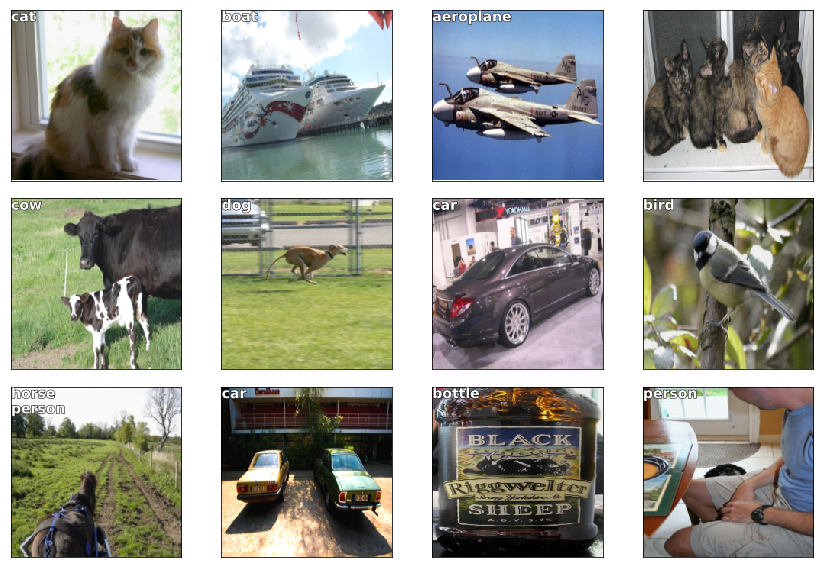

In [164]:
plot_mc(x, preds, 0.5)

## Object Detection with 4x4 Grid of Anchor Boxes

### Setup anchor boxes

In [15]:
grid_size = 4 

def gen_anc_coord(grid_size):
    box_len = (1 - 0)/grid_size
    anc_np = [(0 + i*box_len, 0 + j*box_len, 0 + (i+1)*box_len, 0 + (j+1)*box_len)
           for i in range(grid_size) 
           for j in range(grid_size)]
    return anc_np

In [16]:
anc_np = gen_anc_coord(grid_size)

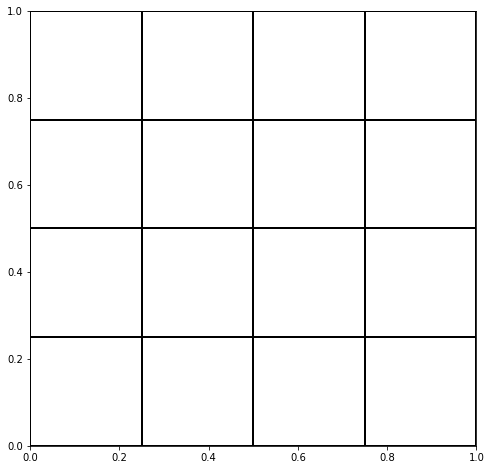

In [17]:
fig, ax = plt.subplots(figsize=(8, 8))
for i, x in enumerate(anc_np):
    bb = bb_hw(x)
    draw_rect(ax, bb, edgecolor='black')

In [18]:
a = torch.Tensor(3, 3).uniform_(0, 1); a


 0.7687  0.1732  0.3308
 0.0743  0.2057  0.8830
 0.3924  0.9165  0.7286
[torch.FloatTensor of size 3x3]

In [19]:
a.index([2, 1, 0]).t().contiguous().view(1, -1)


 0.3924  0.0743  0.7687  0.9165  0.2057  0.1732  0.7286  0.8830  0.3308
[torch.FloatTensor of size 1x9]

### Setup Model Files

In [20]:
def create_od(df):
    df1 = df.copy()
    df1['bbox_np_concat'] = df1['bbox_np'].apply(lambda x: ' '.join([str(i) for i in x]))
    df2 = (df1.groupby(['image_id', 'file_name'])
          .apply(lambda x: pd.Series({'mbb': ' '.join(x.bbox_np_concat),
                                      'mcl': np.array(x.category_id)}))
          .reset_index())
    df2 = (df2[['file_name', 'mbb', 'mcl']]
           .rename(columns={'file_name': 'fname'}))
    return df2

In [21]:
def repack(y):
    return list(zip(list(y[0]), list(y[1])))

In [22]:
def series2dict(s1, s2):
    d = {v:s1[k] for k, v in s2.items()}
    return d

In [23]:
cats = train_df[['category_id', 'category_name']].drop_duplicates().sort_values('category_id')
cat_id = cats.category_id.to_dict() 
cat_name = cats.category_name.to_dict()
id2name = series2dict(cat_name, cat_id)

In [24]:
def plot_gt(img, y, ax=None, figsize=(16, 8), id2name=id2name):
    ax = show_img(img, ax=ax, figsize=figsize)
    m_bb, m_cl = y
    pos_idx = np.where(m_cl > 0)
    m_cl = m_cl[pos_idx]
    m_bb = m_bb[np.min(pos_idx)*4:]
    bb_list = list(np.reshape(m_bb, (int(m_bb.shape[0]/4), 4)))

    for i, bb in enumerate(bb_list):
        draw_rect(ax, bb_hw(bb))
        draw_anno(ax, bb[1], bb[0], id2name[m_cl[i]])

In [133]:
def plot_batch(x, y, boxes=None, ax=None, figsize=(16, 8)):
    y = list(zip(y[0], y[1]))
    nplots = min(12, x.shape[0])
    ncols = min(4, nplots)
    nrows = nplots//ncols + 1
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    for i, ax in enumerate(axes.flat):
        if i >= len(y):
            ax.axis('off')
        else:
            img = np.squeeze(md_mbb.val_ds.denorm(x[i]))
            plot_gt(img, y[i], ax, figsize=figsize)
            if boxes is not None: 
                for j in range(boxes[i].shape[0]):
                    draw_rect(ax, boxes[i][j], edgecolor='red')
    plt.tight_layout()

In [26]:
MBB_CSV = TMP/'MBB.CSV'
od_df = create_od(train_df)
mbb_df = od_df[['fname', 'mbb']]
mcl_df = od_df[['fname', 'mcl']]
mbb_df.to_csv(MBB_CSV, index=False)
mcl_df.to_csv(MC_CSV, index=False)

In [27]:
f_model = resnet34
sz = 224

In [28]:
tfm_y = TfmType.COORD
augs = [RandomFlip(tfm_y=tfm_y, p=0.5),
        RandomRotate(3, tfm_y=tfm_y),
        RandomLighting(0.05, 0.05, tfm_y=tfm_y)]
tfms = tfms_from_model(f_model, sz=sz, aug_tfms=augs, crop_type=CropType.NO, tfm_y=tfm_y)
md_mbb = ImageClassifierData.from_csv(MODEL, JPEGS, MBB_CSV, tfms=tfms, continuous=True)
md_both = ImageClassifierData.from_csv(MODEL, JPEGS, MBB_CSV, tfms=tfms, continuous=True, bs=5)

In [29]:
val_idxs = get_cv_idxs(len(mbb_df.fname))
((val_fnames, trn_fnames), (mcl_val_y, mcl_trn_y)) = split_by_idx(val_idxs, np.array(mcl_df.fname), 
                                                                  mcl_df.mcl.as_matrix())

In [30]:
class ConcatDataSets(Dataset):
    def __init__(self, bb_ds, cl_y):
        self.bb_ds = bb_ds
        self.cl_y = cl_y
        
    def __len__(self):
        return len(self.bb_ds)
    
    def __getitem__(self, i):
        x = self.bb_ds[i][0]
        y = (self.bb_ds[i][1], self.cl_y[i])
        return (x, y)

In [31]:
md_both.trn_dl.dataset = ConcatDataSets(md_mbb.trn_ds, mcl_trn_y)
md_both.val_dl.dataset = ConcatDataSets(md_mbb.val_ds, mcl_val_y)

In [32]:
x, y = next(iter(md_both.val_dl))
x, y = to_np(x), to_np(y)
y = repack(y)

IndexError: index 5 is out of bounds for axis 0 with size 5

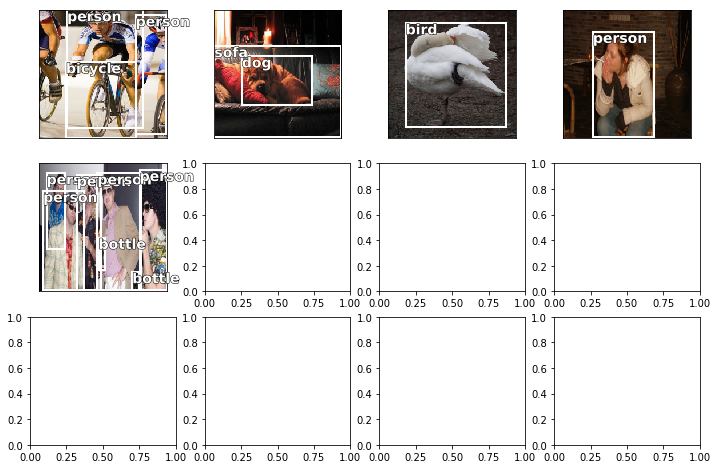

In [33]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i, ax in enumerate(axes.flat):
    img = np.squeeze(md_mbb.val_ds.denorm(x[i]))
    plot_gt(img, y[i], ax, figsize=(12, 8))
plt.tight_layout()

### Build Model

In [34]:
class FeatureExtractor(nn.Module):
    def __init__(orig_model):
        super(FeautureExtractor, self).__init__()
        self.features = nn.Sequential(*list(orig_model.children())[:-1])
    
    def forward(self, x):
        if isinstance(x, torch.autograd.variable.Variable):
            x = self.features(x)
        else:
            x = self.features(V(x))
        return x

In [35]:
class StdConv(nn.Module):
    def __init__(self, in_chan, out_chan, stride=2, drop=0.1):
        super(StdConv, self).__init__()
        self.conv = nn.Conv2d(in_chan, out_chan, 3, stride=stride, padding=1)
        self.bn = nn.BatchNorm2d(out_chan)
        self.dropout = nn.Dropout(drop)
        
    def forward(self, x):
        x = F.relu(self.conv(x))
        x = self.bn(x)
        x = self.dropout(x)
        return x
        
class OutConv(nn.Module):
    def __init__(self, in_chan, num_classes, k=1):
        super(OutConv, self).__init__()
        self.cl_conv = nn.Conv2d(in_chan, num_classes*k, kernel_size=3, padding=1)
        self.loc_conv = nn.Conv2d(in_chan, 4, kernel_size=3, padding=1)
    
    def forward(self, x):
        cl = self.cl_conv(x)
        loc = self.loc_conv(x)       
        return [cl, loc]

In [36]:
class SSDHead(nn.Module):
    def __init__(self, num_classes, k=1):
        super(SSDHead, self).__init__()
        self.drop = nn.Dropout(0.25)
        self.sconv0 = StdConv(512, 256, stride=1)
        self.sconv1 = StdConv(256, 256)
        self.oconv = OutConv(256, num_classes, k=k)
    
    def forward(self, x):
        pdb.set_trace()
        x = self.drop(F.relu(x))
        x = self.sconv0(x)
        x = self.sconv1(x)
        y = self.oconv(x)
        return y

In [177]:
def intersect(bb1_np, bb2_np):
    bb1_ur, bb2_ur = bb1_np[:, None, 2:], bb2_np[None, :, 2:]
    bb1_ll, bb2_ll = bb1_np[:, None, :2], bb2_np[None, :, :2]
    max_xy = torch.min(bb1_ur, bb2_ur)
    min_xy = torch.max(bb1_ll, bb2_ll)
    inter = torch.clamp(max_xy - min_xy, min=0)
    area = inter[:, :, :1]*inter[:, :, 1:]
    return area

In [178]:
def area_bb(bb_np):
    delta = bb_np[:, 2:] - bb_np[:, :2]
    return delta[:, 0]*delta[:, 1]

In [179]:
def union(bb1_np, bb2_np):
    return (area_bb(bb1_np)[:, None, None] + 
            area_bb(bb2_np)[None, :, None] -
            intersect(bb1_np, bb2_np))

In [180]:
def jacard(bb1_np, bb2_np):
    iou = intersect(bb1_np, bb2_np)/union(bb1_np, bb2_np)
    return iou.squeeze()

## Testing

In [155]:
x, y = next(iter(md_both.val_dl))
x, y = to_np(x), to_np(y)
box_1s = np.array(anc_np)*224; box_1s
bb_0 = np.reshape(y[0][2], (-1, 4))
intersect(torch.from_numpy(bb_0), torch.from_numpy(box_1s.astype('float32')))


(0 ,.,.) = 
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0

(1 ,.,.) = 
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0

(2 ,.,.) = 
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0

(3 ,.,.) = 
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0

(4 ,.,.) = 
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0

(5 ,.,.) = 
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0

(6 ,.,.) = 
   858
  1848
  1848
  1221
  1456
  3136
  3136
  2072
  1456
  3136
  3136
  2072
   962
  2072
  2072
  1369
[torch.FloatTensor of size 7x16x1]

In [181]:
jacard(torch.from_numpy(bb_0), torch.from_numpy(box_1s.astype('float32')))



Columns 0 to 9 
1.00000e-02 *
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  2.5141  5.5767  5.5767  3.6162  4.3424  9.8462  9.8462  6.2952  4.3424  9.8462

Columns 10 to 15 
1.00000e-02 *
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  9.8462  6.2952  2.8274  6.2952  6.2952  4.0723
[torch.FloatTensor of siz

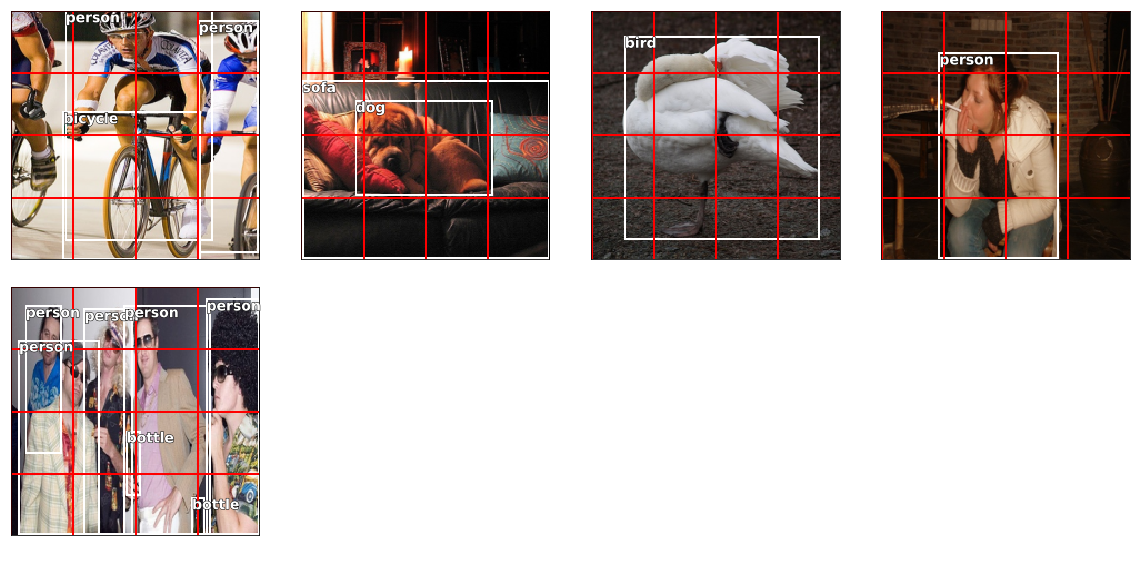

In [134]:
boxes = np.repeat(np.array(anc_np)[None, :, :], x.shape[0], 0)
plot_batch(x, y, boxes*224)

In [97]:
def overlap_old(bb1_np, bb2_np):
    bb1_y1, bb1_x1, bb1_y2, bb1_x2 = bb1_np
    bb2_y1, bb2_x1, bb2_y2, bb2_x2 = bb2_np
    lx = max(bb1_x1, bb2_x1)
    ux = min(bb1_x2, bb2_x2)
    ly = max(bb1_y1, bb2_y1)
    uy = min(bb1_y2, bb2_y2)
    dx = ux - lx
    dy = uy - ly
    if ((dx > 0) & (dy > 0)):
        return dx*dy
    else:
        return 0

In [ ]:
def union(bb1_np, bb2_np):
    bb1_y1, bb1_x1, bb1_y2, bb1_x2 = bb1_np
    bb2_y1, bb2_x1, bb2_y2, bb2_x2 = bb2_np

In [36]:
head = SSDHead(len(id2name) + 1)
model = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/ubuntu/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:01<00:00, 71357901.24it/s]


In [124]:
bb1 = [int(x) for x in mbb_df.mbb.iloc[np.random.randint(len(mbb_df))].split(' ')]
bb2 = [int(x) for x in mbb_df.mbb.iloc[np.random.randint(len(mbb_df))].split(' ')]
bb1 = bb1[:4]
bb2= bb2[:4]

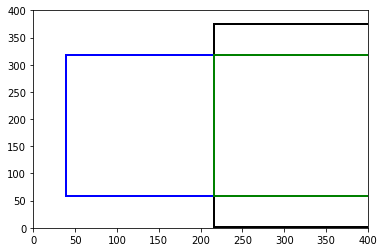

In [128]:
fig, ax = plt.subplots()
ax.set_xlim(0, 400)
ax.set_ylim(0, 400)
draw_rect(ax, bb_hw(bb1), 'black')
draw_rect(ax, bb_hw(bb2), 'blue')
draw_rect(ax, bb_hw(iou(bb1, bb2)), 'green')

In [62]:
iou(bb, bb)

[96, 155, 270, 351]

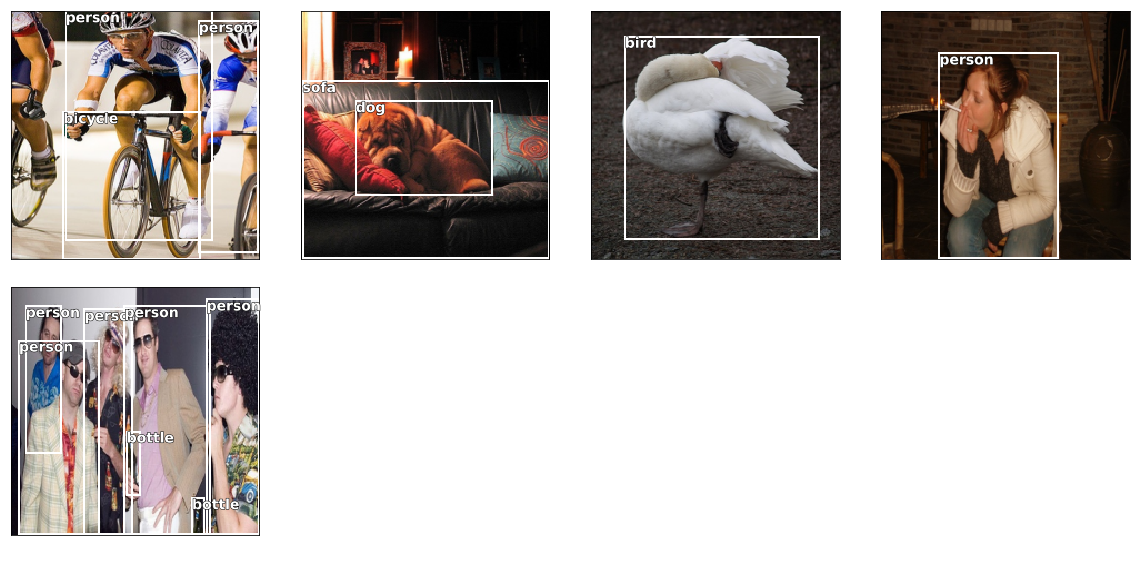

In [39]:
x, y = next(iter(md_both.val_dl))
x, y = to_np(x), to_np(y)
plot_batch(x, y)

In [43]:
x[0]

array([[[ 0.39125,  0.43014,  0.48172, ...,  0.17518,  0.32367,  0.40783],
        [ 0.51636,  0.44973,  0.59202, ...,  0.17386,  0.23164,  0.36722],
        [ 0.54416,  0.57267,  0.70099, ...,  0.05768,  0.2232 ,  0.35455],
        ...,
        [ 1.46039,  1.50291,  1.5195 , ...,  0.7803 ,  0.56716, -0.63922],
        [ 0.93739,  1.021  ,  1.15993, ...,  1.12806,  1.08947,  0.45857],
        [ 0.58584,  0.45245,  0.29605, ...,  1.00028,  0.92495,  0.82729]],

       [[ 0.24041,  0.31444,  0.41422, ...,  0.33162,  0.47052,  0.54764],
        [ 0.39737,  0.42156,  0.57304, ...,  0.33887,  0.38799,  0.52038],
        [ 0.52462,  0.58245,  0.67485, ...,  0.2519 ,  0.40003,  0.51502],
        ...,
        [ 1.47208,  1.50185,  1.50771, ...,  0.60917,  0.44337, -0.73978],
        [ 0.84169,  0.94566,  1.06783, ...,  0.97373,  1.01637,  0.39674],
        [ 0.47731,  0.36442,  0.1823 , ...,  0.85592,  0.85008,  0.75529]],

       [[ 0.63094,  0.76758,  0.91924, ...,  0.46997,  0.58218,  0.635

In [35]:
def one_hot_embedding(pred, num_classes):
    
class BCELoss(nn.Module):
    def __init__(self):
        super(BCELoss, self).__init__()
    
    def forward(self, pred, targ):
        

IndentationError: expected an indented block (<ipython-input-35-10784636e641>, line 3)

In [38]:
learn = ConvLearner(md_both, model)
learn.opt_fn = optim.Adam

In [39]:
learn.fit(lrs=0.01, n_cycle=1)

  0%|          | 0/401 [00:00<?, ?it/s]> <ipython-input-36-e3159bcc9191>(11)forward()
-> x = self.drop(F.relu(x))
(Pdb) l
  6  	        self.sconv1 = StdConv(256, 256)
  7  	        self.oconv = OutConv(256, num_classes, k=k)
  8  	
  9  	    def forward(self, x):
 10  	        pdb.set_trace()
 11  ->	        x = self.drop(F.relu(x))
 12  	        x = self.sconv0(x)
 13  	        x = self.sconv1(x)
 14  	        y = self.oconv(x)
 15  	        return y
[EOF]
(Pdb) n
> <ipython-input-36-e3159bcc9191>(12)forward()
-> x = self.sconv0(x)
(Pdb) x.size()
torch.Size([5, 512, 7, 7])
(Pdb) n
> <ipython-input-36-e3159bcc9191>(13)forward()
-> x = self.sconv1(x)
(Pdb) x.size()
torch.Size([5, 256, 7, 7])
(Pdb) n
> <ipython-input-36-e3159bcc9191>(14)forward()
-> y = self.oconv(x)
(Pdb) x.size()
torch.Size([5, 256, 4, 4])
(Pdb) n
> <ipython-input-36-e3159bcc9191>(15)forward()
-> return y
(Pdb) y.size()
*** AttributeError: 'list' object has no attribute 'size'
(Pdb) y[0].size()
torch.Size([5, 21, 4, 4

BdbQuit: 